In [ ]:
"""author: Vetivert? 💐 
created: 30/04/2025 @ 18:27:50"""

# LOAD DATA

In [95]:
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib as mpl # type: ignore
import pandas as pd # type: ignore
import seaborn as sns # type: ignore

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV # type: ignore
from sklearn.preprocessing import StandardScaler, label_binarize # type: ignore
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, make_scorer # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from scipy.stats import randint, uniform # type: ignore
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
import os

current_dir = os.path.abspath('')

parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.utils.prefix_path import *
from src.utils.functions import *

In [96]:
# Load dataset
df = pd.read_csv(FULL_DATA_PATH, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(REDUNDANT_ROWS, inplace=True)
df.index = range(len(df)) #reset index
df.drop(REDUNDANT_COLS, axis=1, inplace=True)

df.fillna(FILLNA_VALUES) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases
df.iloc[np.where(df == '8(nặng xin về)')] = 8

for i in HEART_INDEX:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    print(f"{i}: {df[str(i)].mean()}")
print("\nDiastolic BP < 80: Huyết áp tối ưu \nSystolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp")

# df.drop(HEART_INDEX, axis=1, inplace=True)

uniques, counts = np.unique(df['Diagnosis'], return_counts=True)
print('\nDiagnosis\'s classes: ',dict(zip(uniques, np.round(counts * 100 / len(df['Diagnosis']), 2))))
# df['Diagnosis'] = np.where(df['Diagnosis'] == '3', '2', df['Diagnosis'])
df['Day of illness'] = np.where(df['Day of illness'] == '55', '5', df['Day of illness'])
df['Systolic BP'] = np.where(df['Systolic BP'] == 1120, 120, df['Systolic BP'])


# hematoma group
hema = df[HEMATOMA_COLS]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(HEMATOMA_COLS[0]), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(HEMATOMA_COLS, axis=1, inplace=True)

# bleeding group
bleed = df[BLEEDING_COLS]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(BLEEDING_COLS[0]), 'Mucosa membrane bleeding', bleed['stacked_int'])
df.drop(BLEEDING_COLS, axis=1, inplace=True)

# additional diseases group
add_diseases = df[ADDITIONAL_DISEASES]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(ADDITIONAL_DISEASES[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(ADDITIONAL_DISEASES, axis=1, inplace=True)


Pulse rate: 89.60148514851485
Systolic BP: 117.25
Diastolic BP: 70.63861386138613

Diastolic BP < 80: Huyết áp tối ưu 
Systolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp

Diagnosis's classes:  {'1': 56.4, '2': 39.66, '3': 3.94}


# DISTRIBUTION OF EACH COL

In [97]:
df = df[['AST1','AST2','AST3','AST4','AST5','AST6','AST7','AST8','AST9','PLT1','PLT2','PLT3','PLT4','PLT5','PLT6','PLT7','PLT8','PLT9','Diagnosis']]
df = df.apply(pd.to_numeric, errors='coerce')

In [45]:
df['Diagnosis']

0      2
1      1
2      1
3      2
4      1
      ..
401    2
402    2
403    1
404    2
405    3
Name: Diagnosis, Length: 406, dtype: int64

79     54.0
160     NaN
254    16.0
259     2.0
301     NaN
318    87.0
320     NaN
326    48.0
327     NaN
333    13.0
345     NaN
347     NaN
348    12.0
393     NaN
395    12.0
405    12.0
Name: PLT5, dtype: float64


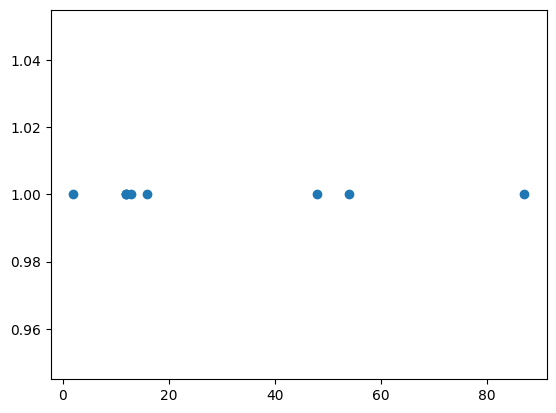

In [140]:
print(df.loc[df['Diagnosis'] == 3, 'PLT5'])

plt.plot(df.loc[df['Diagnosis'] == 3, 'PLT5'], [1] * len(df.loc[df['Diagnosis'] == 3, 'PLT5']), 'o')
plt.show()


In [151]:
def distribution_plot(df_x, x_name: str):
    y = np.random.rand(df_x.shape[0]) * 10
    x_3 = df_x.loc[df_x['Diagnosis'] == 3, x_name]
    x_2 = df_x.loc[df_x['Diagnosis'] == 2, x_name]
    x_1 = df_x.loc[df_x['Diagnosis'] == 1, x_name]

    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))

    im = ax[0].scatter(df_x[x_name], y, c=df['Diagnosis'], alpha=0.75)
    ax[0].set_xlabel(x_name + ' Values')
    ax[0].set_xlim(0, 400)
    ax[0].set_ylim(-0.25, 10.25)
    ax[0].set_yticks([])

    ax[1].scatter(x_3, [3/60] * len(x_3), label = 'Diagnosis 3', color='red')
    ax[1].scatter(x_2, [2/60] * len(x_2), label = 'Diagnosis 2',color='turquoise')
    ax[1].scatter(x_1, [1/60] * len(x_1), label = 'Diagnosis 1',color='purple')
    ax[1].vlines(np.max(x_3), 0, 3/60, label = f'{np.max(x_3)}: max value of Diagnosis 3', color='red', alpha=0.5, linestyle="--")
    ax[1].vlines(np.max(x_2), 0, 2/60, label = f'{np.max(x_2)}: max value of Diagnosis 2', color='turquoise', alpha=0.5, linestyle="--")
    ax[1].vlines(np.max(x_1), 0, 1/60, label = f'{np.max(x_1)}: max value of Diagnosis 1', color='purple', alpha=0.5, linestyle="--")

    sns.kdeplot(x_3, ax=ax[1], color='red')
    sns.kdeplot(x_2, ax=ax[1], color='turquoise')
    sns.kdeplot(x_1, ax=ax[1], color='purple')
    ax[1].legend()
    ax[1].set_yticks([])


    fig.colorbar(im, ticks = [1,2,3], values = [1,2,3], ax = ax[0], label='Diagnosis')
    fig.suptitle(x_name + ' Distribution by Diagnosis', fontsize=16)
    plt.show()

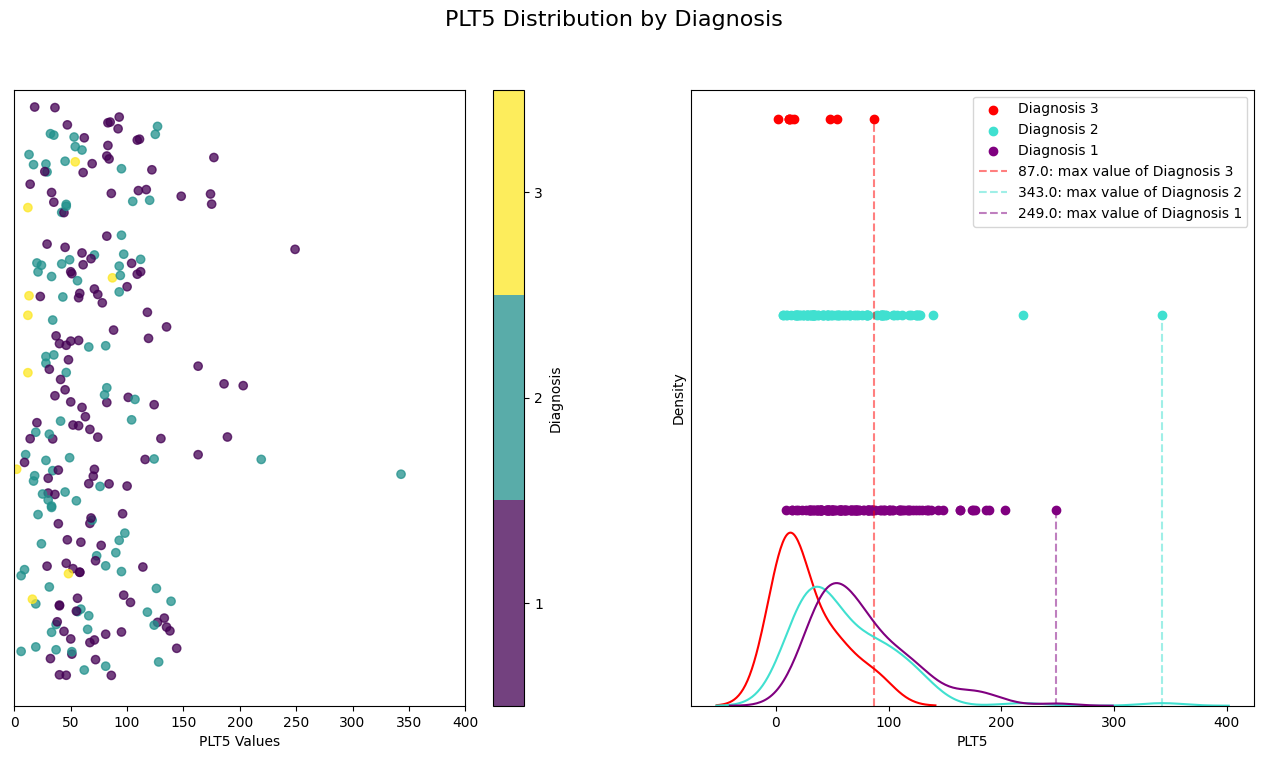

In [152]:
distribution_plot(df, 'PLT5')

# REGRESSION OF PAIRS

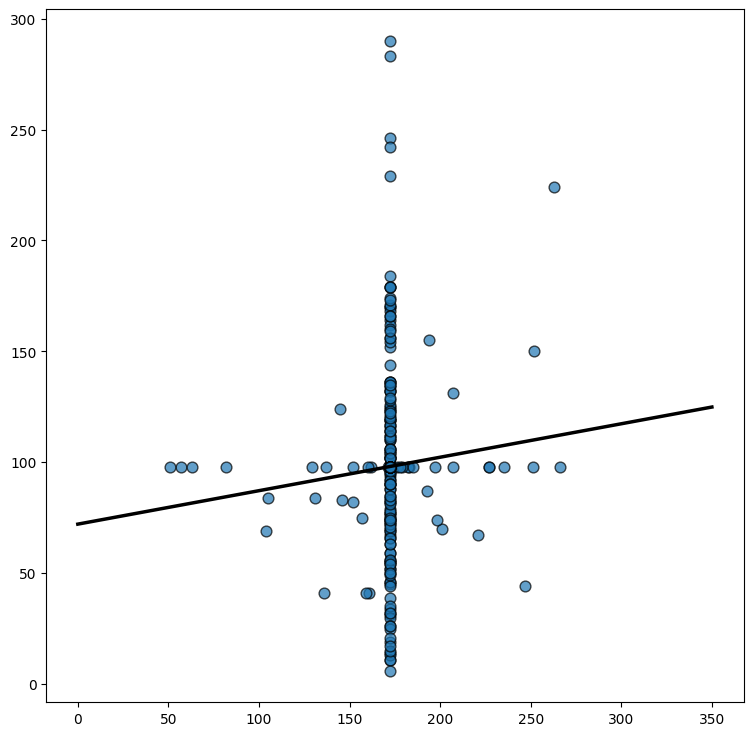

In [172]:
# Initialize layout
fig, ax = plt.subplots(figsize=(9, 9))
y_PLT = 'PLT4'
x = df['PLT1'].fillna(np.mean(df['PLT1']))
y = df[y_PLT].fillna(np.mean(df[y_PLT]))
# Add scatterplot
ax.scatter(x, y, s=60, alpha=0.7, edgecolors="k")

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(0, 350, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)